# A Fast and Robust Fourier Option Pricing Method: Defining a Truncation Range Formula Explicitly for Various Advanced Stock Price Models: Supporting $\texttt{.ipynb}$ notebook

***Import Libraries, Remove Deprecation Warnings, Find Software Version***

In [1]:
# Python Version
from platform import python_version
print(str('Python Version: ') + python_version())

# Vectorise code using numpy
import numpy as np
print(str('Numpy Version: ') + np.version.version)

# Time the COS Method
import time
# time is built in to python - version is the same as the python instillation

# Remove numpy complex number deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings is built in to python - version is the same as the python instillation

# Scipy intergrate for HSV Model
from scipy.integrate import quad

# For Variance Gamma
import scipy.stats as ss
import scipy as scp

# Norm function from Scipy States - normal cdf
from scipy.stats import norm
print(str('Scipy Version: ') + scp.__version__)

# Math for factorial function
import math
# Math is built in to python - version is the same as the python instillation

# Plotting testing
import matplotlib 
import matplotlib.pyplot as plt
print(str('Matplotlib Version: ') + matplotlib.__version__)

Python Version: 3.9.7
Numpy Version: 1.20.3
Scipy Version: 1.7.1
Matplotlib Version: 3.4.3


# Implementation of the COS method

***First, we need a function for $\chi_k$ and $\psi_k$, as defined in the report and below***

$$ 
\begin{align*}
    \chi_k(c,d) &= \int^d_c e^y\text{cos}\left(k\pi\frac{y-a}{b-a} \right)dy\\
    &= \frac{1}{1+\left(\frac{k \pi}{b-a}\right)^2}\left[\cos \left(k \pi \frac{d-a}{b-a}\right) \mathrm{e}^d-\cos \left(k \pi \frac{c-a}{b-a}\right) \mathrm{e}^c\right.  \\
    & \left.+\frac{k \pi}{b-a} \sin \left(k \pi \frac{d-a}{b-a}\right) \mathrm{e}^d-\frac{k \pi}{b-a} \sin \left(k \pi \frac{c-a}{b-a}\right) \mathrm{e}^c\right] 
\end{align*}
$$ 

$$ 
\begin{align*}
    \psi_k(c,d) &= \int^d_c \text{cos}\left(k\pi\frac{y-a}{b-a} \right)dy\\
    &=\begin{cases}
        \left[\sin \left(k \pi \frac{d-a}{b-a}\right)-\sin \left(k \pi \frac{c-a}{b-a}\right)\right] \frac{b-a}{k \pi} & k \neq 0 \\
        (d-c) & k=0
    \end{cases} 
\end{align*}
$$

In [2]:
def Psi(a,b,c,d,k):

    # Formula for all the psi values
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    
    # When k not equal to 0
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)

    # When k = 0
    psi[0] = d - c

    # Return all psi's
    return -psi

def Chi(a,b,c,d,k):

    # Outside of the square brackets
    chi_out = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 

    # First half inside the square brackets
    chi_in_1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)

    # Second half inside the square brackets
    chi_in_2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)

    # Bringing them all together
    chi = chi_out * (chi_in_1 + chi_in_2)

    # Return all chi's
    return -chi

***Building a function for $H_k$ using $\chi_k$ and $\psi_k$. This function takes truncation range M and k***

$$
\begin{align*}
    H_k^{\text{Call}} &= \frac{2}{b-a}\int^b_0 K(e^y - 1)\text{cos}\left( \frac{y - a}{b-a}\right)dy\\
    &=\frac{2}{b-a}K(\chi_k(0,b) - \psi_k(0,b)) \\
    \text{similarly,} \hspace{0.3cm}H_k^{\text{Put}} &= \frac{2}{b-a}K( \psi_k(a,0) - \chi_k(a,0)) 
\end{align*}
$$

In [3]:
def Hk(a,b,k):
    
    # On the interval [-M,0]
    c = a
    d = 0.0

    # Get a chi_k and psi_k value from the chi and psi function based on this M
    Chi_k = Chi(a,b,c,d,k)
    Psi_k = Psi(a,b,c,d,k)

    # define the H_ks
    H_k  = 2.0 / (b - a) *  -(Psi_k - Chi_k)

    # Return the H_k's
    return H_k    

***Building the function for the COS Method, 1 strike at time t - leave room changing this to an np.array of strikes for the COS Speedy method later***


$$
V^{\text{PUT}}_{\text{COS}}(M,N)=e^{-rT}\sum_{k=0}^{N-1   ,}\text{Re}\bigg\{ \varphi_X \left( \frac{k\pi}{2M}e^{2^{-1}(ik\pi) }\right)\bigg\}\cdot H_k 
$$
With,
$$
a = -M = -b = \sqrt[4]{\frac{2K\mu_4}{\varepsilon}} = \sqrt[8]{\frac{2\mu_4}{\varepsilon}} \cdot \sqrt[4]{K} \quad \text{and} \quad V^{\text{Call}}_{\text{COS}} = V^{\text{Put}}_{\text{COS}}(M,N,T) +S -Ke^{rT}
$$
And additional condition,
$$
\text{ln}\left(\frac{K}{S_0 e^{-rT}} \right) < M \quad \Rightarrow \quad V^{\text{PUT}}_{\text{COS}} = 0
$$

In [4]:
def COS(CP,cf,S0,r,T,K,mu_4):

    # Define M
    M = np.power((2*K*mu_4)/(10**-7), (1/4))

    # Define N as z*M. I have chose 1,000 here to ensure accuracy in most cases
    N = int(1_000 * M)
    
    # Setting some constants for the summation
    i = np.complex(0.0,1.0) 
    y = np.log(S0 / K)   
    
    # Setting the truncation domain [-M,M]
    a = - M
    b = M
    
    # Create a column vector of the (in fang and osterlee's notation) v_{k}^{M}
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Grab the put coefficients based on this truncation domain  
    H_k = Hk(a,b,k)

    # Now doing the sum
    sumation = cf(u) * H_k 
        # Halfing the first value (sum ')
    sumation[0] = 0.5 * sumation[0]    
    
    # Outer product
    outerproduct = np.exp(i * np.outer((y - a) , u))

    # Final result, discount and *K * real part of the dot product of the summation and the outerproduct variable
    output = np.exp(-r * T) * K * np.real(outerproduct.dot(sumation))
        
    # Implenting the condition for the forward    
    Forwards = float(S0 * np.exp(-r*T))
    ftest = np.log(K/Forwards)
    
    if ftest < a:
        out = 0
    else:
        out = float(output[:,0][0])

    if CP == "put":
        price = out
    elif CP == "call":
        price = out + S0 - K*np.exp(-r*T)

    # Return this output
    return price

# Implementing the Augmented COS Method in a Variety of Advanced Stock Price Models

### Geometric Brownian Motion

***Closed Form Solution***

In [5]:
# Closed form solution for Black Scholes put and call prices

N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)   

***Now the cumulants and moments functions***

In [6]:
# Cumulants in GBM

def cumulants_GBM(r,sgm,T):
    return r - 0.5 * ( sgm**2 ) * T, ( sgm**2 ) * T, 0, 0

# Moments in GBM

def moment_func_GBM(r,sgm,T):
    mus = cumulants_GBM(r,sgm,T)
    return mus[3] + 4 * mus[2] * mus[0] + 3 * ( mus[1]**2 ) + 5 * mus[1] * ( mus[0]**2 ) + ( mus[3]**4 )

***The COS Method***

In [7]:
# Implementing the COS Method in GBM

# Set i to be complex 1 real 0
i=np.complex(0.0,1.0)

# Set testing parameters
S0 = 100.0
r = 0.1
T = 0.1
sgm = 0.25
CP = "put"

# Define characteristic function
cf = lambda u: np.exp((r - 0.5 * np.power(sgm,2.0)) * i * u * T - 0.5 
                        * np.power(sgm, 2.0) * np.power(u, 2.0) * T)

cos_vals_puts = []
bs_vals_puts = []
errors_puts = []

# Loop accross a range of strikes
for K_ in range(1,300):
    # Find the 4th moment
    mu_4 = moment_func_GBM(r,T,sgm)

    # Value using COS
    cosPrice = COS(CP,cf,S0,r,T,K_,mu_4)
    cos_vals_puts.append(cosPrice)

    # Valueing via black and scholes
    bsPrice = BS_PUT(S0,K_,T,r,sgm)
    bs_vals_puts.append(bsPrice)

    # Find the error
    error = abs(bsPrice - cosPrice)
    errors_puts.append(error)

# Redefine CP
CP = "call"

cos_vals_calls = []
bs_vals_calls = []
errors_calls = []

# Loop accross a range of strikes
for K_ in range(1,300):
    # Find the 4th moment
    mu_4 = moment_func_GBM(r,T,sgm)

    # Value using COS
    cosPrice = COS(CP,cf,S0,r,T,K_,mu_4)
    cos_vals_calls.append(cosPrice)

    # Valueing via black and scholes
    bsPrice = BS_CALL(S0,K_,T,r,sgm)
    bs_vals_calls.append(bsPrice)

    # Find the error
    error = abs(bsPrice - cosPrice)
    errors_calls.append(error)

***Plotting Results***

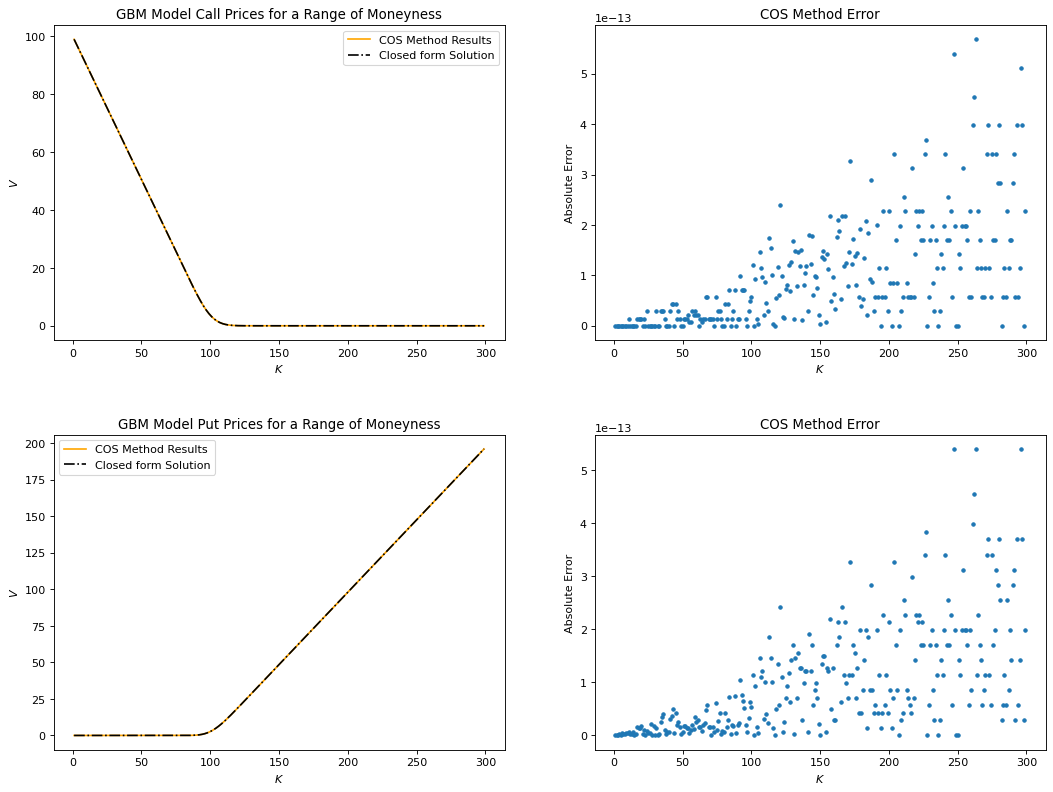

In [8]:
cp_range = range(1,300)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16, 12), dpi=80)
ax1.plot(cp_range, cos_vals_calls, label ="COS Method Results", color = "orange")
ax1.plot(cp_range, bs_vals_calls, label ="Closed form Solution", linestyle = "-.", color = "k")
ax1.set_title("GBM Model Call Prices for a Range of Moneyness")
ax1.legend()
ax1.set_xlabel("$K$")
ax1.set_ylabel("$V$")

ax2.scatter(cp_range, errors_calls, marker = ".")
ax2.set_xlabel("$K$")
ax2.set_ylabel("Absolute Error")
ax2.set_title("COS Method Error")

ax3.plot(cp_range, cos_vals_puts, label ="COS Method Results", color = "orange")
ax3.plot(cp_range, bs_vals_puts, label ="Closed form Solution", linestyle = "-.", color = "k")
ax3.set_title("GBM Model Put Prices for a Range of Moneyness")
ax3.legend()
ax3.set_xlabel("$K$")
ax3.set_ylabel("$V$")

ax4.scatter(cp_range, errors_puts, marker = ".")
ax4.set_xlabel("$K$")
ax4.set_ylabel("Absolute Error")
ax4.set_title("COS Method Error")

fig.subplots_adjust(hspace=0.3)

#fig.savefig(r"testing_GBM_Calls.svg", format="svg", dpi=1200)

***Perform the speedtesting***

In [9]:
# Speedtest

x = []
start = time.time()
for K_ in range(1,300):
    x.append(COS("put",cf,S0,r,T,K_,mu_4))
end = time.time()

print(end-start)

y = []
start = time.time()
for K_ in range(1,300):
    y.append(BS_PUT(S0,K_,T,r,sgm))
end = time.time()

print(end-start)

1.0745327472686768
0.03493905067443848


### The Merton Jump Diffusion Model

***Closed Form Solution***

In [10]:
# Closed form solution for Puts and Calls

def mjd_PUT(S,K,r,sgm,k,v,lam,T):
    lamd = lam*(1+k)
    gamma = np.log(1 + k)
    p = 0
    for n in range(0,99):
        coef = (np.exp(-lamd*T) * ((lamd*T)**n)) / math.factorial(n)
        v_n_2 = np.sqrt((sgm**2) + (n*(v**2)/T))
        r_n = r - lam*(k) + (n * gamma)/T
        BS = BS_PUT(S,K,T,r_n, v_n_2)
        p += coef*BS
    return p

def mjd_CALL(S,K,r,sgm,k,v,lam,T):
    lamd = lam*(1+k)
    gamma = np.log(1 + k)
    p = 0
    for n in range(0,99):
        coef = (np.exp(-lamd*T) * ((lamd*T)**n)) / math.factorial(n)
        v_n_2 = np.sqrt((sgm**2) + (n*(v**2)/T))
        r_n = r - lam*(k) + (n * gamma)/T
        BS = BS_CALL(S,K,T,r_n, v_n_2)
        p += coef*BS
    return p

***Cumulants and Moments Functions***

In [11]:
# Cumulants in MJD

def cumulants_MJD(k,sgm,lam,r,T,delta):
    muj = np.log(k + 1) - 0.5 * ( delta**2 )
    w_hat = lam * ( np.exp ( 0.5 * ( delta**2 ) + mu_j ) -1 )
    mu = r - ( sgm**2 ) - w_hat
    c1 = T * (r - w_hat - 0.5*(sgm**2) + lam*mu_j)
    c2 = T * (sgm**2 + lam * ( delta**2 ) + lam * ( delta**2 ) )
    c3 = T * lam * (3*mu_j*(delta**2) + (mu_j**3))
    c4 = T * lam * ( ( mu_j**4 ) + 6 * ( delta**2 ) * ( mu_j**2 ) + 3 * ( delta**4 ) * lam )
    return c1, c2, c3, c4

# Moments in MJD

def moment_func_MJD(k,sgm,lam,r,T,sgm_j):
    mus = cumulants_MJD(k,sgm,lam,r,T,sgm_j)
    return mus[3] + 4 * mus[2] * mus[0] + 3 *( mus[1]**2 ) + 5 * mus[1] * ( mus[0]**2 ) + ( mus[3]**4 )

***Implementing the COS Method in MJD***

In [12]:
## Implementing the COS method in MJD

CP = "put"
S0 = 100
r = 0
T = 0.1
sgm = 0.1
lam = 0.001
kappa = -0.5
delta = 0.2

# Find model variables
mu_j = np.log(kappa + 1) - 0.5*(delta**2)
# Mu used in charteristic function below
mu_c = r - ((sgm**2)/2) - lam*(np.exp(0.5*(delta**2) + mu_j) -1)

# Characteristic function
cf = lambda u: np.exp((i * u * mu_c * T) - (0.5 * (sgm**2) * (u**2) * T)) * \
            np.exp(lam * T * (np.exp((i * mu_j * u) - (0.5* (delta**2) * (u**2))) -1))

# Find the 4th moment
mu_4 = moment_func_MJD(kappa,sgm,lam,r,T,delta)

cos_vals_puts = []
bs_vals_puts = []
errors_puts = []

# Loop accross a range of strikes
for K_ in range(1,300):
    # Find the 4th moment
    mu_4 = moment_func_MJD(kappa,sgm,lam,r,T,delta)

    # Value using COS
    cosPrice = COS("put",cf,S0,r,T,K_,mu_4)
    cos_vals_puts.append(cosPrice)

    # Valueing via black and scholes
    bsPrice = mjd_PUT(S0,K_,r,sgm,kappa,delta,lam,T)
    bs_vals_puts.append(bsPrice)

    # Find the error
    error = abs(bsPrice - cosPrice)
    errors_puts.append(error)

# Redefine CP
CP = "call"

cos_vals_calls = []
bs_vals_calls = []
errors_calls = []

# Loop accross a range of strikes
for K_ in range(1,300):
    # Find the 4th moment
    mu_4 = moment_func_MJD(kappa,sgm,lam,r,T,delta)

    # Value using COS
    cosPrice = COS("call",cf,S0,r,T,K_,mu_4)
    cos_vals_calls.append(cosPrice)

    # Valueing via black and scholes
    bsPrice = mjd_CALL(S0,K_,r,sgm,kappa,delta,lam,T)
    bs_vals_calls.append(bsPrice)

    # Find the error
    error = abs(bsPrice - cosPrice)
    errors_calls.append(error)

***Graphing the results***

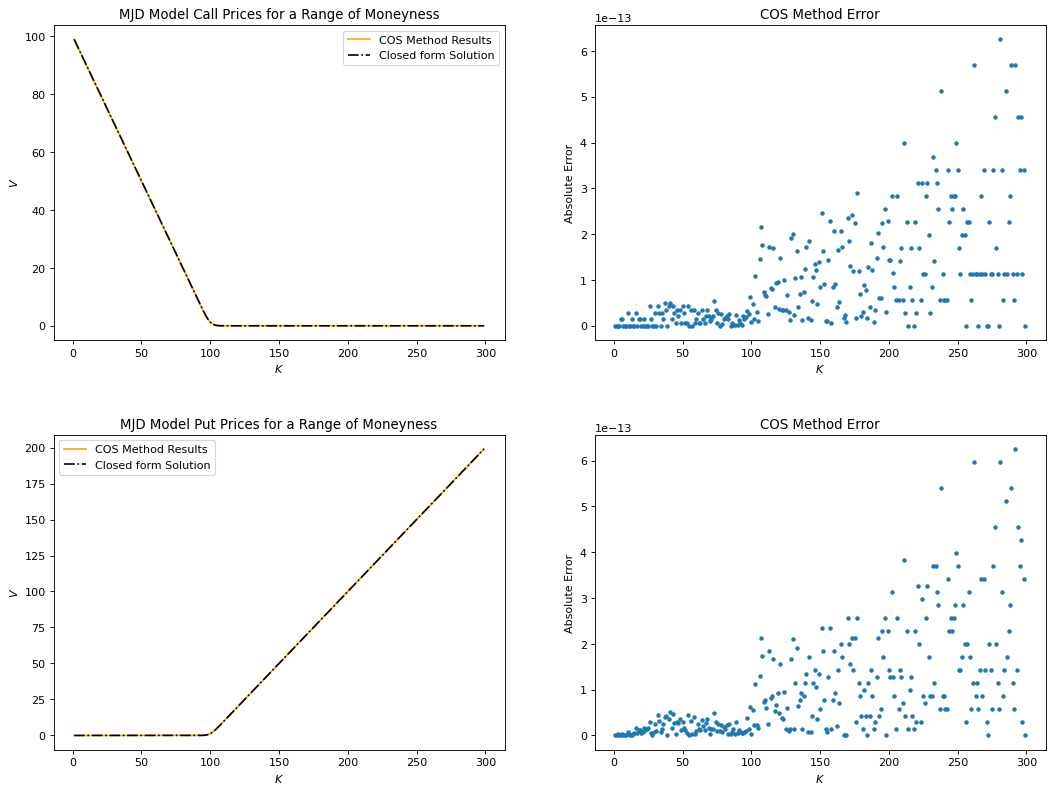

In [13]:
# Graphing the results

cp_range = range(1,300)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16, 12), dpi=80)
ax1.plot(cp_range, cos_vals_calls, label ="COS Method Results", color = "orange")
ax1.plot(cp_range, bs_vals_calls, label ="Closed form Solution", linestyle = "-.", color = "k")
ax1.set_title("MJD Model Call Prices for a Range of Moneyness")
ax1.legend()
ax1.set_xlabel("$K$")
ax1.set_ylabel("$V$")

ax2.scatter(cp_range, errors_calls, marker = ".")
ax2.set_xlabel("$K$")
ax2.set_ylabel("Absolute Error")
ax2.set_title("COS Method Error")

ax3.plot(cp_range, cos_vals_puts, label ="COS Method Results", color = "orange")
ax3.plot(cp_range, bs_vals_puts, label ="Closed form Solution", linestyle = "-.", color = "k")
ax3.set_title("MJD Model Put Prices for a Range of Moneyness")
ax3.legend()
ax3.set_xlabel("$K$")
ax3.set_ylabel("$V$")

ax4.scatter(cp_range, errors_puts, marker = ".")
ax4.set_xlabel("$K$")
ax4.set_ylabel("Absolute Error")
ax4.set_title("COS Method Error")

fig.subplots_adjust(hspace=0.3)

#fig.savefig(r"testing_MJD_Calls.svg", format="svg", dpi=1200)

***Performing the speedtest***

In [14]:
# Performing the speedtest

x = []
start = time.time()
for K_ in range(1,300):
    x.append(COS(CP,cf,S0,r,T,K_,mu_4))
end = time.time()

print(end-start)

x = []
start = time.time()
for K_ in range(1,300):
    x.append(mjd_CALL(S0,K_,r,sgm,kappa,delta,lam,T))
end = time.time()

print(end-start)

0.8635749816894531
3.2072908878326416


### Heston Stochastic Volatility

***Closed Form Solution (From Chapter 15 - Fundamentals of Derivative Security Pricing)***

In [15]:
# Heston Closed Form Solution

class Heston:
    def __init__(self,S0,v0,r,k,theta,eta,rho):
        self.S0 = S0
        self.v0 = v0
        self.r = r
        self.k = k
        self.theta = theta
        self.eta = eta
        self.rho = rho
        self.gamma = eta**2/2.0
    def P(self,j,x,tau):
        return 0.5+1.0/np.pi*(quad(self.integrand,0.0,np.inf,args=(j,x,self.v0,tau)))[0]
    def integrand(self,u,j,x,v,tau):
        return np.real(np.exp(self.C(j,u,tau)*self.theta+self.D(j,u,tau)*v+1j*u*x)/(u*1j))
    def C(self,j,u,tau):
        g = self.rminus(j,u)/self.rplus(j,u)
        return self.k*(self.rminus(j,u)*tau-2.0/self.eta**2*np.log((1.0-g*np.exp(-self.d(j,u)*tau))/(1.0-g)))
    def d(self,j,u):
        return np.sqrt(self.beta(j,u)**2-4*self.alpha(j,u)*self.gamma)
    def rminus(self,j,u):
        return (self.beta(j,u) - self.d(j,u))/(2*self.gamma)
    def rplus(self,j,u):
        return (self.beta(j,u) + self.d(j,u))/(2*self.gamma)
    def beta(self,j,u):
        return self.k-self.rho*self.eta*j-self.rho*self.eta*u*1j
    def alpha(self,j,u):
        return -u**2/2-u*1j/2+j*u*1j
    def D(self,j,u,tau):
        g = self.rminus(j,u)/self.rplus(j,u)
        return self.rminus(j,u)*(1.0-np.exp(-self.d(j,u)*tau))/(1.0-g*np.exp(-self.d(j,u)*tau))
    def callprice(self,strike,tau):
        B = np.exp(-self.r*tau)
        F = self.S0/B
        x = np.log(F/strike)
        return B*(F*self.P(1,x,tau)-strike*self.P(0,x,tau))

***Defining the Characteristic Function***

In [16]:
def ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rho):
    i = np.complex(0.0,1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*np.exp(-D1(u)*tau)))\
                    *(kappa-gamma*rho*i*u-D1(u))
    A = lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*u-D1(u))\
                - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
    # Characteristic function for the Heston model
    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf

***Defining the 4th Moment***

In [17]:
# Defining the 4th moment in Heston

def Heston_mu4(k,r,theta,eta):
    first = 1/(k*(k-2.0))
    second = (k**2)*(r**4) + 4*(k**3)*(r**3) + 6*(k**2)*(r**2)*theta - 2*(k**2)*(r**2) + 12*(k**2)*r*theta
    third = 3*(k**2)*(theta*2) - 8*(k**1)*(r**3) - 12*(k**1)*(r**2)*theta + 4*(k**2)*r + 6*(k**2)*theta - 12*(k**1)*(r**2) - 24*k*r*theta
    fourth = -6*(k**1)*(theta**2) - 3*(eta**2)*(theta**1) + (k**2) - 8*(k**1)*(r**1) - 12*(k**1)*(theta) - 2*(k**1)
    return first*(second + third + fourth)

***Implementing the COS Method***

In [18]:
# The COS Method for Heston Stochastic Volatility

# Set i to be complex 1 real 0
i=np.complex(0.0,1.0)

S0 = 100.0
v0 = 0.1**2
theta = 0.1**2
r = np.log(1.0005)
k = 1.0
eta = 0.3
rho = 0.2
K = [100]
tau = 0.5
CP = "call"

# Define characteristic function
cf = ChFHestonModel(r,tau,k,eta,theta,v0,rho)

# Find the 4th moment
mu_4 = Heston_mu4(k,r,theta,eta)

# Define Heston Closed Form
hestonmodel = Heston(S0,v0,r,k,theta,eta,rho)

cos_vals_puts = []
heston_vals_puts = []
errors_puts = []

# Loop accross a range of strikes
for K_ in range(1,300):
    # Find the 4th moment

    # Value using COS
    cosPrice = COS("put",cf,S0,r,tau,K_,mu_4)
    cos_vals_puts.append(cosPrice)

    # Valueing via Heston
    hs_price_put = hestonmodel.callprice(K_,tau) + K_*np.exp(-r*tau) - S0
    heston_vals_puts.append(hs_price_put)

    # Find the error
    error = abs(hs_price_put - cosPrice)
    errors_puts.append(error)

# Redefine CP
CP = "call"

cos_vals_calls = []
heston_vals_calls = []
errors_calls = []

# Loop accross a range of strikes
for K_ in range(1,300):

    # Value using COS
    cosPrice = COS("call",cf,S0,r,tau,K_,mu_4)
    cos_vals_calls.append(cosPrice)

    # Valueing via Heston
    hs_price_call = hestonmodel.callprice(K_,tau) 
    heston_vals_calls.append(hs_price_call)

    # Find the error
    error = abs(hs_price_call - cosPrice)
    errors_calls.append(error)

/var/folders/dk/m2kmqtj92zl9w8bs05bskkgr0000gn/T/ipykernel_23328/2300009589.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 0.5+1.0/np.pi*(quad(self.integrand,0.0,np.inf,args=(j,x,self.v0,tau)))[0]


***Graphing the Results***

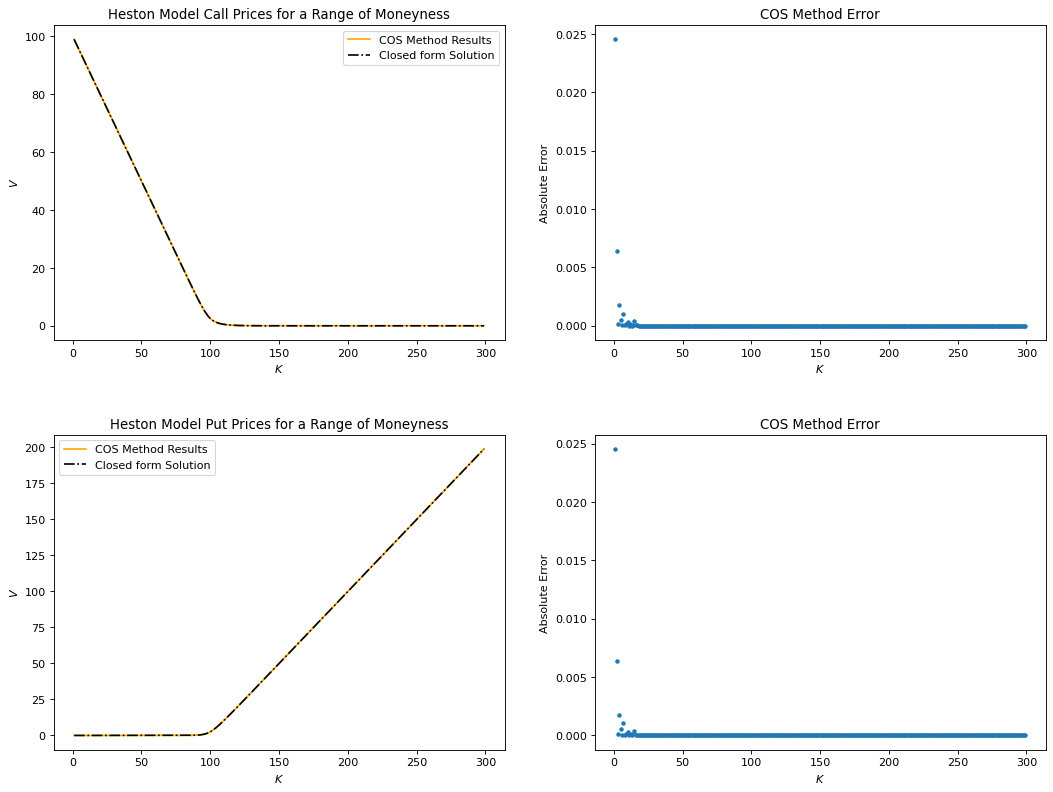

In [19]:
# Graphing the results

cp_range = range(1,300)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16, 12), dpi=80)
ax1.plot(cp_range, cos_vals_calls, label ="COS Method Results", color = "orange")
ax1.plot(cp_range, heston_vals_calls, label ="Closed form Solution", linestyle = "-.", color = "k")
ax1.set_title("Heston Model Call Prices for a Range of Moneyness")
ax1.legend()
ax1.set_xlabel("$K$")
ax1.set_ylabel("$V$")

ax2.scatter(cp_range, errors_calls, marker = ".")
ax2.set_xlabel("$K$")
ax2.set_ylabel("Absolute Error")
ax2.set_title("COS Method Error")

ax3.plot(cp_range, cos_vals_puts, label ="COS Method Results", color = "orange")
ax3.plot(cp_range, heston_vals_puts, label ="Closed form Solution", linestyle = "-.", color = "k")
ax3.set_title("Heston Model Put Prices for a Range of Moneyness")
ax3.legend()
ax3.set_xlabel("$K$")
ax3.set_ylabel("$V$")

ax4.scatter(cp_range, errors_puts, marker = ".")
ax4.set_xlabel("$K$")
ax4.set_ylabel("Absolute Error")
ax4.set_title("COS Method Error")

fig.subplots_adjust(hspace=0.3)

#fig.savefig(r"testing_Heston_Calls.svg", format="svg", dpi=1200)

***Investigating Errors***

/var/folders/dk/m2kmqtj92zl9w8bs05bskkgr0000gn/T/ipykernel_23328/2300009589.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 0.5+1.0/np.pi*(quad(self.integrand,0.0,np.inf,args=(j,x,self.v0,tau)))[0]


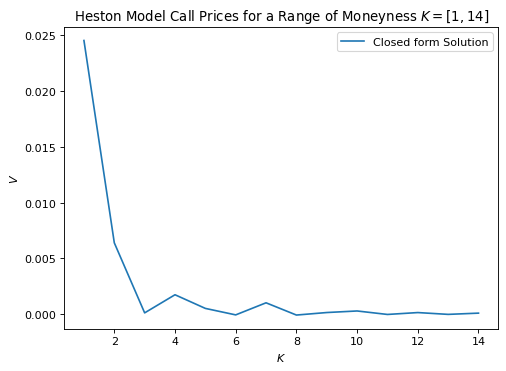

In [20]:
new_range = range(1,15)

testtt = []
testttt= []
for i in range(1,15):
    hs_price_call = hestonmodel.callprice(i,tau) + i*np.exp(-r*tau) - S0
    testtt.append(hs_price_call)

fig, ax1 = plt.subplots(1,1, figsize=(7, 5), dpi=80)
ax1.plot(new_range, testtt, label ="Closed form Solution", linestyle = "-")
ax1.set_title("Heston Model Call Prices for a Range of Moneyness $K = [1,14]$")
ax1.legend()
ax1.set_xlabel("$K$")
ax1.set_ylabel("$V$")
fig.savefig(r"heston_error.svg", format="svg", dpi=1200)

***Speedtest***

In [21]:
# Performing the speedtest

x = []
start = time.time()
for K_ in range(1,300):
    x.append(COS(CP,cf,S0,r,tau,K_,mu_4))
end = time.time()

print(end-start)

x = []
start = time.time()
for K_ in range(1,300):
    x.append(hestonmodel.callprice(K_,tau))
end = time.time()

print(end-start)

30.804718017578125


/var/folders/dk/m2kmqtj92zl9w8bs05bskkgr0000gn/T/ipykernel_23328/2300009589.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 0.5+1.0/np.pi*(quad(self.integrand,0.0,np.inf,args=(j,x,self.v0,tau)))[0]


17.841031074523926


### Variance Gamma

***Cumulants and Moments for Variance Gamma***

In [22]:
# Cumulants in Variance Gamma

def VG_cumulants(r,t,v,theta,sigma):
    wbar = 1/v * np.log(1 - theta*v * - 0.5*(sigma**2)*v)
    c1 = (r - wbar + theta)*t
    c2 = t*((sigma**2) + kappa*(theta**2))
    c3 = t*(2*(theta**3)*(v**2) + 3*(sigma**2)*theta*v)
    c4 =  3*( (sigma**4)*v + 2*(theta**4)*(v**3) + 4*(sigma**2)*(theta**2)*(v**2) )*t
    return c1, c2, c3, c4

# Moments function in Variance Gamma

def VG_mu4(r,t,v,theta,sigma):
    mus = VG_cumulants(r,t,v,theta,sigma)
    return mus[3] + 4 * mus[2] * mus[0] + 3 *( mus[1]**2 ) + 5 * mus[1] * ( mus[0]**2 ) + ( mus[3]**4 )

***Characteristic Function for Variance Gamma***

In [23]:
# Variance Gamma Characteristic Function

def ChFVG(t,r,v,theta,sigma):
    i = np.complex(0.0,1.0)
    omega = 1/v * np.log(1.0-v*theta-0.5*v*sigma*sigma)
    mu = r + omega
    cf = lambda u: np.exp(i*u*mu*t)*np.power(1.0-i*v*theta*u+0.5*v*sigma*sigma*u*u,-t/v)
    return cf

***VG MC Method***

In [24]:
def VG_MonteCarlo(N,S0,K,v,theta,sigma,r,T):
    y = 1 / v
    w = -np.log(1 - (theta * v) - (v/2 * sigma**2)) /v
    G = ss.gamma(y * T).rvs(N) / y
    normRVs = ss.norm.rvs(0,1,N) 
    S_T = S0 * np.exp( ((r-w)*T) + (theta * G) + (sigma * np.sqrt(G) * normRVs))
    call_price = np.exp(-r*T) * scp.mean( np.maximum(S_T-K,0) )
    bound_C = 2*(scp.std(np.maximum(S_T - K, 0)))/np.sqrt(N)
    return call_price, bound_C

In [25]:
# Implementing the COS Method

S0 = 100
T = 1/12
r = 0.1
kappa = 0.2
sigma = 0.12
theta = -0.14

# Characteristic function
cf = ChFVG(T,r,kappa,theta,sigma)

# Find the 4th moment
mu_4 = VG_mu4(r,T,kappa,theta,sigma)

# Create a set of empty lists
MC_Price = []
lower_c = []
upper_c = []
cosPriceVG_call = []

# Loop over the strikes, find COS Method Price and MC Price in given params above for call prices only
for K_ in range(1,300):
    c, bc = VG_MonteCarlo(1_000_000,100,K_,kappa,theta,sigma,r,T)
    MC_Price.append(c)
    lower_c.append(c - bc)
    upper_c.append(c + bc)
    cosPriceVG_call.append(COS("call",cf,S0,r,T,K_,mu_4))

***Speedtest***

In [26]:
## Speed test - only speedtest COS Variance Gamma Puts (MC known to be slow)

start = time.time()
for i in range(1,300):
    COS("put",cf,S0,r,T,K_,mu_4)
end = time.time()

print(end - start)

1.146420955657959


***Plotting Results***

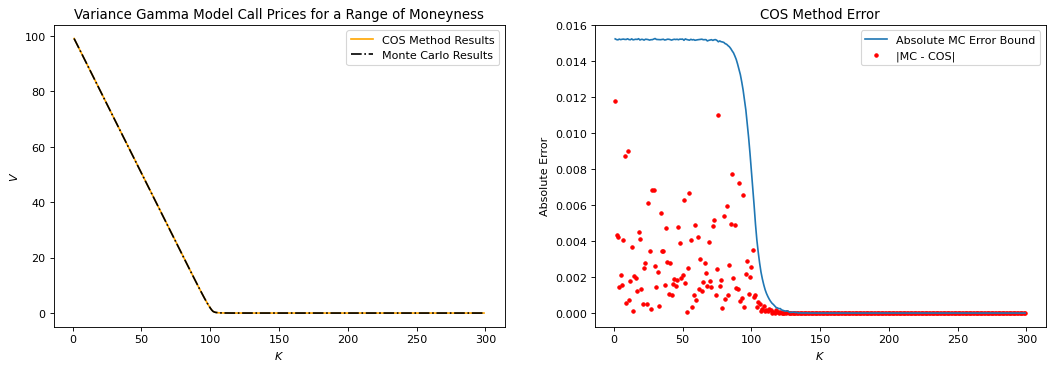

In [27]:
# Graphing the results

cp_range = range(1,300)

# MC Error Bound and the COS Error

ebs_c = []
eb_c = []

for i in range(0,len(lower_c)):
    eb_c.append(abs(cosPriceVG_call[i] - MC_Price[i]))
    ebs_c.append(abs(lower_c[i] - upper_c[i]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5), dpi=80)
ax1.plot(cp_range, cosPriceVG_call, label ="COS Method Results", color = "orange")
ax1.plot(cp_range, MC_Price, label ="Monte Carlo Results", linestyle = "-.", color = "k")
ax1.set_title("Variance Gamma Model Call Prices for a Range of Moneyness")
ax1.legend()
ax1.set_xlabel("$K$")
ax1.set_ylabel("$V$")

ax2.plot(cp_range, ebs_c, label = "Absolute MC Error Bound")
ax2.scatter(cp_range, eb_c, label = "|MC - COS|", marker = ".", color = 'r')
ax2.set_xlabel("$K$")
ax2.legend()
ax2.set_ylabel("Absolute Error")
ax2.set_title("COS Method Error")

fig.subplots_adjust(hspace=0.3)

#fig.savefig(r"testing_VG_Calls.svg", format="svg", dpi=1200)

# Finding a Solution for Speed

## Re-defining the COS method to take a range of strikes and a max truncation range - Remove formulas that can be calculated prior to calling $\texttt{COS\_Speedy}$

***Re-defining the COS Method, the $\texttt{COS\_Speedy}$ function***

In [28]:
def COS_speedy(cf,S0,r,T,K,M,N):
    
    # Setting some constants for the summation
    i = np.complex(0.0,1.0) 
    y = np.log(S0 / K)   
    
    # Setting the truncation domain [-M,M]
    a = - M
    b = M
    
    # Create a column vector of the (in fang and osterlee's notation) v_{k}^{M}
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Grab the put coefficients based on this truncation domain  
    H_k = Hk(a,b,k)

    # Now doing the sum
    sumation = cf(u) * H_k 
        # Halfing the first value (sum ')
    sumation[0] = 0.5 * sumation[0]    
    
    # Outer product
    outerproduct = np.exp(i * np.outer((y - a) , u))

    # Final result, discount and *K * real part of the dot product of the summation and the outerproduct variable
    output = np.exp(-r * T) * K * np.real(outerproduct.dot(sumation))
        
    # Implenting the condition for the forward    
    Forwards = float(S0 * np.exp(-r*T))
    ftest = np.log(K/Forwards)

    test = np.where(ftest < a, 0, output)

    # Return this output
    return test

## Testing in Various Advanced Stock Price Models

### Testing in GBM

In [29]:
# COS Speedy in GBM

# Set i to be complex 1 real 0
i=np.complex(0.0,1.0)

# Set testing parameters
S0 = 100.0
r = 0.1
T = 0.1
sgm = 0.25
CP = "put"

# Define characteristic function
cf = lambda u: np.exp((r - 0.5 * np.power(sgm,2.0)) * i * u * T - 0.5 
                        * np.power(sgm, 2.0) * np.power(u, 2.0) * T)

# Taking out pre-calculatable variables from the cos method
K = range(1,300)
K_ = np.array(K).reshape([len(K),1])
max_strike = 299
mu4 = moment_func_GBM(r,T,sgm)
M = np.power((2*max_strike*mu_4)/(10**-7), (1/4))

# Speedtest
start = time.time()
x = (COS_speedy(cf,S0,r,T,K_, M, int(1000)))
end = time.time()
print(end-start)

test = []
start = time.time()
for K_ in range(1,300):
    test.append(BS_PUT(S0,K_,T,r,sgm))
end = time.time()
print(end-start)

0.02427816390991211
0.05109405517578125


***Plot Results***

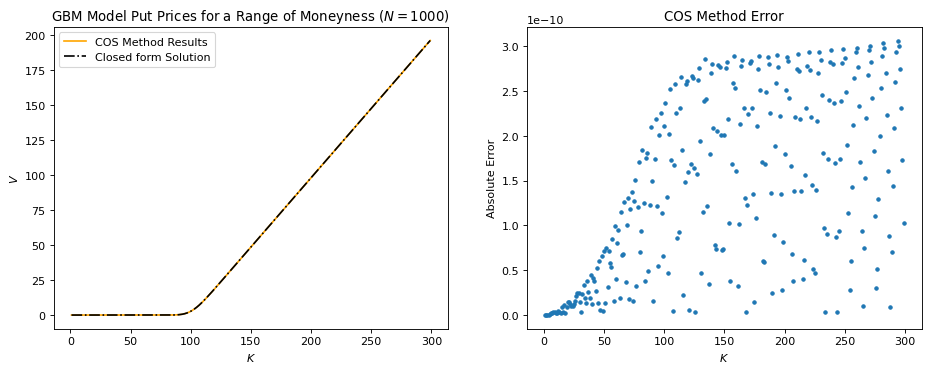

In [30]:
cp_range = range(1,300)

ep = []
for i in range(0,len(x)):
    ep.append(abs(test[i] - x[i]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 5), dpi=80)
ax1.plot(cp_range, x, label ="COS Method Results", color = "orange")
ax1.plot(cp_range, test, label ="Closed form Solution", linestyle = "-.", color = "k")
ax1.set_title("GBM Model Put Prices for a Range of Moneyness ($N = 1000$)")
ax1.legend()
ax1.set_xlabel("$K$")
ax1.set_ylabel("$V$")

ax2.scatter(cp_range, ep, marker = ".")
ax2.set_xlabel("$K$")
ax2.set_ylabel("Absolute Error")
ax2.set_title("COS Method Error")

fig.subplots_adjust(hspace=0.3)

#fig.savefig(r"testing_GBM_Calls.svg", format="svg", dpi=1200)

### Testing in MJD

***Redefine the closed form formula here***

In [31]:
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)   

def mjd_PUT(S,K,r,sgm,k,v,lam,T):
    lamd = lam*(1+k)
    gamma = np.log(1 + k)
    p = 0
    for n in range(0,99):
        coef = (np.exp(-lamd*T) * ((lamd*T)**n)) / math.factorial(n)
        v_n_2 = np.sqrt((sgm**2) + (n*(v**2)/T))
        r_n = r - lam*(k) + (n * gamma)/T
        BS = BS_PUT(S,K,T,r_n, v_n_2)
        p += coef*BS
    return p

def mjd_CALL(S,K,r,sgm,k,v,lam,T):
    lamd = lam*(1+k)
    gamma = np.log(1 + k)
    p = 0
    for n in range(0,99):
        coef = (np.exp(-lamd*T) * ((lamd*T)**n)) / math.factorial(n)
        v_n_2 = np.sqrt((sgm**2) + (n*(v**2)/T))
        r_n = r - lam*(k) + (n * gamma)/T
        BS = BS_CALL(S,K,T,r_n, v_n_2)
        p += coef*BS
    return p

In [32]:
## Implementing the COS speedy method in MJD

i = np.complex(0.0, 1.0)

S0 = 100
r = 0
T = 0.1
sgm = 0.1
lam = 0.001
kappa = -0.5
delta = 0.2

# Find model variables
mu_j = np.log(kappa + 1) - 0.5*(delta**2)
# Mu used in charteristic function below
mu_c = r - ((sgm**2)/2) - lam*(np.exp(0.5*(delta**2) + mu_j) -1)

# Characteristic function
cf = lambda u: np.exp((i * u * mu_c * T) - (0.5 * (sgm**2) * (u**2) * T)) * \
            np.exp(lam * T * (np.exp((i * mu_j * u) - (0.5* (delta**2) * (u**2))) -1))

# Taking out pre-calculatable variables from the cos method
K = range(1,300)
K_ = np.array(K).reshape([len(K),1])
max_strike = 299
mu_4 = moment_func_MJD(kappa,sgm,lam,r,T,delta)
M = np.power((2*max_strike*mu_4)/(10**-7), (1/4))

# Speedtest
start = time.time()
x = (COS_speedy(cf,S0,r,T,K_, M, int(1000)))
end = time.time()
print(end-start)

test = []
start = time.time()
for K_ in range(1,300):
    test.append(mjd_PUT(S0,K_,r,sgm,kappa,delta,lam,T))
end = time.time()
print(end-start)

0.012730836868286133
3.2221341133117676


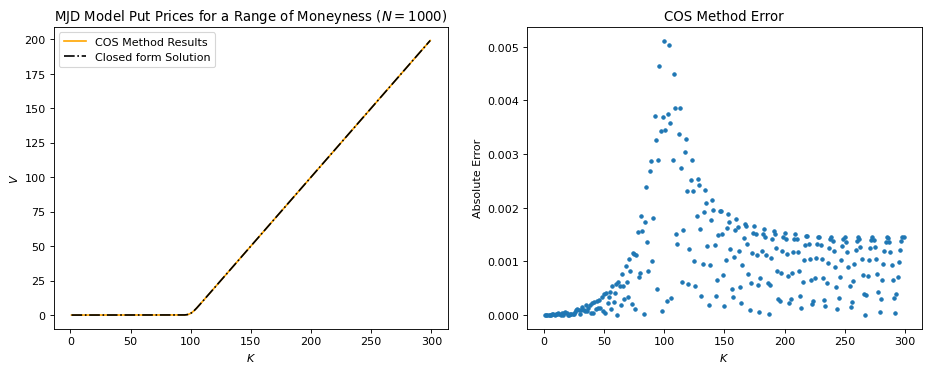

In [33]:
cp_range = range(1,300)

ep = []
for i in range(0,len(x)):
    ep.append(abs(test[i] - x[i]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 5), dpi=80)
ax1.plot(cp_range, x, label ="COS Method Results", color = "orange")
ax1.plot(cp_range, test, label ="Closed form Solution", linestyle = "-.", color = "k")
ax1.set_title("MJD Model Put Prices for a Range of Moneyness ($N = 1000$)")
ax1.legend()
ax1.set_xlabel("$K$")
ax1.set_ylabel("$V$")

ax2.scatter(cp_range, ep, marker = ".")
ax2.set_xlabel("$K$")
ax2.set_ylabel("Absolute Error")
ax2.set_title("COS Method Error")

fig.subplots_adjust(hspace=0.3)

#fig.savefig(r"testing_COS_cs2_Calls.svg", format="svg", dpi=1200)

### Testing in Heston

In [34]:
i=np.complex(0.0,1.0)

S0 = 100.0
v0 = 0.1**2
theta = 0.1**2
r = np.log(1.0005)
k = 1.0
eta = 0.3
rho = 0.2
tau = 0.5

# Define characteristic function
cf = ChFHestonModel(r,tau,k,eta,theta,v0,rho)

# Find the 4th moment
mu_4 = Heston_mu4(k,r,theta,eta)

# Define Heston Closed Form
hestonmodel = Heston(S0,v0,r,k,theta,eta,rho)


K = range(1,300)
K_ = np.array(K).reshape([len(K),1])
max_strike = 229
mu_4 = Heston_mu4(k,r,theta,eta)
M = np.power((2*max_strike*mu_4)/(10**-7), (1/4))

# Speedtest
start = time.time()
x = (COS_speedy(cf,S0,r,tau,K_, M, int(10_000)))
end = time.time()
print(end-start)

test = []
start = time.time()
for K_ in range(1,300):
    test.append(hestonmodel.callprice(K_,tau) + K_*np.exp(-r*tau) - S0)
end = time.time()
print(end-start)

0.12619900703430176


/var/folders/dk/m2kmqtj92zl9w8bs05bskkgr0000gn/T/ipykernel_23328/2300009589.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 0.5+1.0/np.pi*(quad(self.integrand,0.0,np.inf,args=(j,x,self.v0,tau)))[0]


17.784496068954468


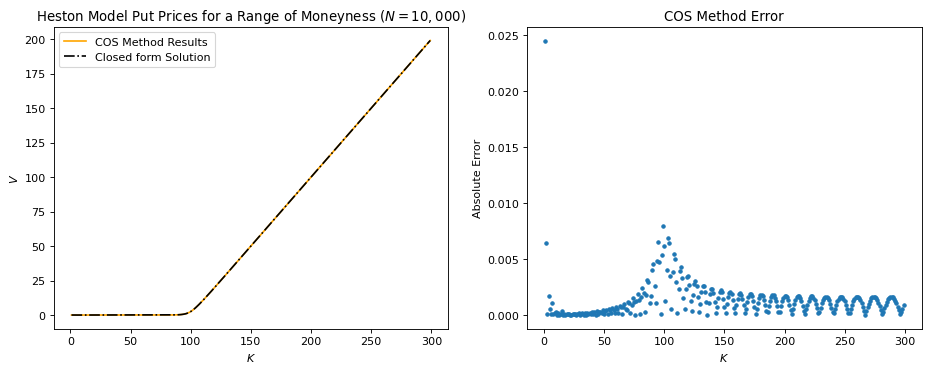

In [35]:
cp_range = range(1,300)

ep = []
for i in range(0,len(x)):
    ep.append(abs(test[i] - x[i]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 5), dpi=80)
ax1.plot(cp_range, x, label ="COS Method Results", color = "orange")
ax1.plot(cp_range, test, label ="Closed form Solution", linestyle = "-.", color = "k")
ax1.set_title("Heston Model Put Prices for a Range of Moneyness ($N = 10,000$)")
ax1.legend()
ax1.set_xlabel("$K$")
ax1.set_ylabel("$V$")

ax2.scatter(cp_range, ep, marker = ".")
ax2.set_xlabel("$K$")
ax2.set_ylabel("Absolute Error")
ax2.set_title("COS Method Error")

fig.subplots_adjust(hspace=0.3)

#fig.savefig(r"testing_FINALGRAPH_Calls.svg", format="svg", dpi=1200)

### Testing in Variance Gamma

***Implementing the COS Speedy Method***

In [37]:
# Implementing the COS speedy method in variance gamma

S0 = 100
T = 1/12
r = 0.1
kappa = 0.2
sigma = 0.12
theta = -0.14
K = range(1,300)
K_ = np.array(K).reshape([len(K),1])
max_strike = 299
mu4 = VG_mu4(r,T,kappa,theta,sigma)
M = np.power((2*max_strike*mu_4)/(10**-7), (1/4))

# Characteristic function
cf = ChFVG(T,r,kappa,theta,sigma)


start = time.time()
y = (COS_speedy(cf,S0,r,T,K_, M, int(100_000)))
end = time.time()
print(end-start)

# call put parity
COSVGSpeedy = []
for i in range(0,len(y)):
    COSVGSpeedy.append(y[i] - ((i+1) * np.exp(-r*T)) + S0)

# Empty lists
MC_Price = []
lower_c = []
upper_c = []

# Find MC Result
for K_ in range(1,300):
    c, bc = VG_MonteCarlo(1_000_000,100,K_,kappa,theta,sigma,r,T)
    MC_Price.append(c)
    lower_c.append(c - bc)
    upper_c.append(c + bc)

# Find the errors
VG_errors = []
for i in range(0,len(y)):
    VG_errors.append(abs(MC_Price[i] - COSVGSpeedy[i]))

# Absolute MC error bound
ebs_c = []

for i in range(0,len(lower_c)):
    ebs_c.append(abs(lower_c[i] - upper_c[i]))

1.4703161716461182


***Plotting Results***

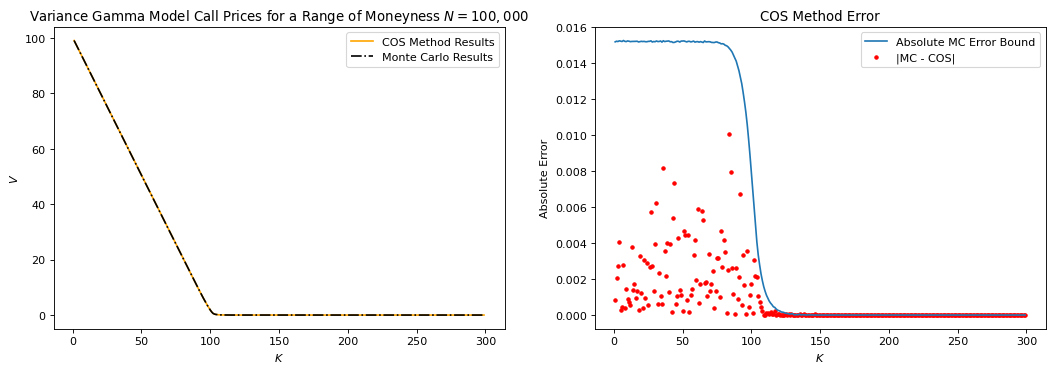

In [38]:
# Graphing the results

cp_range = range(1,300)

# MC Error Bound and the COS Error

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5), dpi=80)
ax1.plot(cp_range, COSVGSpeedy, label ="COS Method Results", color = "orange")
ax1.plot(cp_range, MC_Price, label ="Monte Carlo Results", linestyle = "-.", color = "k")
ax1.set_title("Variance Gamma Model Call Prices for a Range of Moneyness $N = 100,000$")
ax1.legend()
ax1.set_xlabel("$K$")
ax1.set_ylabel("$V$")

ax2.plot(cp_range, ebs_c, label = "Absolute MC Error Bound")
ax2.scatter(cp_range, VG_errors, label = "|MC - COS|", marker = ".", color = 'r')
ax2.set_xlabel("$K$")
ax2.legend()
ax2.set_ylabel("Absolute Error")
ax2.set_title("COS Method Error")

fig.subplots_adjust(hspace=0.3)

#fig.savefig(r"testing_VG_Calls_speedy.svg", format="svg", dpi=1200)